#  Sentiment Analysis of movies reviews

In [1]:
#Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Load Data 

### Train set

In [2]:
df_train = pd.read_csv('Data/Train.csv')
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
df_train['text'] = df_train['text'].str.replace("<br />", " ")

In [4]:
text_train, y_train = df_train.text, df_train.label

In [5]:
#In case you didn't replace in the DataFrame
#text_train = [doc.replace("<br />", " ") for doc in text_train]

In [6]:
print(f'length of text_train :{len(text_train)}')

length of text_train :40000


In [7]:
#Binary classification
y_train.unique()

array([0, 1])

In [8]:
print(f'Samples per class: {np.bincount(y_train)}')

Samples per class: [20019 19981]


### Test set

In [9]:
df_test = pd.read_csv('Data/Test.csv')
df_test.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [10]:
df_test['text'] = df_test['text'].str.replace("<br />", " ")

In [11]:
text_test, y_test = df_test.text, df_test.label

In [12]:
#In case you didn't replace in the DataFrame
#text_test = [doc.replace("<br />", " ") for doc in text_test]

In [13]:
print(f'length of text_test :{len(text_test)}')

length of text_test :10000


In [14]:
y_test.unique()

array([0, 1])

In [15]:
print(f'Samples per class: {np.bincount(y_test)}')

Samples per class: [4981 5019]


In [16]:
#Repartition of the datasets
print(f'length of train set : {len(df_train)} (80%)')
print(f'length of test set : {len(df_test)} (20%)')

length of train set : 40000 (80%)
length of test set : 10000 (20%)


## EDA

In [17]:
#Join all positive and all negative reviews together
text_pos = " ".join(df_train['text'][df_train.label==1])
text_neg = " ".join(df_train['text'][df_train.label==0])

In [18]:
en_nlp = spacy.load('en')
stopwords = set(en_nlp.Defaults.stop_words)
stopwords.update(['movie','film','br','one','make','see','time','even','character'])

In [19]:
tv = Image.open('Images/television.png')
#tv = tv.resize((500,250))
tv_mask = np.array(tv)

In [20]:
# Function to transform all white part of the mask. It should be 255 (Pure white)
#def transform_format(val):
#    if val == 0:
#        return 255
#    else:
#        return val

In [21]:
# Applying the function to create the mask
#transformed_tv_mask = np.ndarray((tv_mask.shape[0],tv_mask.shape[1]), np.int32)

#for i in range(len(tv_mask)):
#    transformed_tv_mask[i] = list(map(transform_format, tv_mask[i]))

In [22]:
wc_pos = WordCloud(background_color="white", max_words=100, mask=tv_mask,
               stopwords=stopwords, contour_width=3, contour_color='green')
wc_neg = WordCloud(background_color="white", max_words=100, mask=tv_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

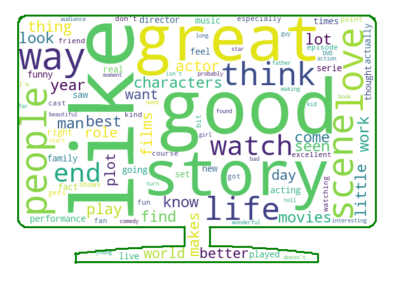

In [23]:
#Word cloud for positive reviews
wc_pos.generate(text_pos)

# show
plt.figure(figsize=[15,5])
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

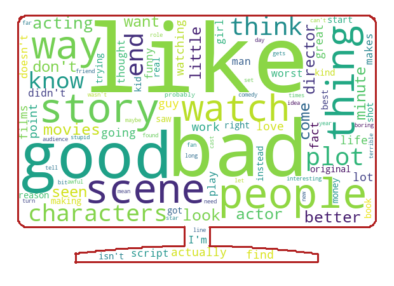

In [24]:
#Word cloud for negative reviews
wc_neg.generate(text_neg)

# show
plt.figure(figsize=[15,5])
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.show()
#We found like and good in negative reviews

In [25]:
#Save WordCloud
wc_pos.to_file('Images/WordCloud_Positive.png')
wc_neg.to_file('Images/WordCloud_Negative.png')

## Modelling

### CountVectorizer

In [26]:
#Bag of Words
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train:\n{repr(X_train)}")

X_train:
<40000x92908 sparse matrix of type '<class 'numpy.int64'>'
	with 5440408 stored elements in Compressed Sparse Row format>


In [27]:
feature_names = vect.get_feature_names()
print(f"Number of features: {len(feature_names)}")
print(f"First 20 features:\n{feature_names[:20]}")

Number of features: 92908
First 20 features:
['00', '000', '00000000000', '0000000000001', '00000001', '00001', '000dm', '000s', '001', '007', '0079', '007s', '0080', '0083', '009', '00am', '00o', '00pm', '00s', '01']


In [28]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores)}")

Mean cross-validation accuracy: 0.8873749999999999


In [29]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {np.round(grid.best_score_,3)}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.893
Best parameters: {'C': 0.1}


In [30]:
X_test = vect.transform(text_test)
print(f"Test score: {np.round(grid.score(X_test, y_test),3)}")

Test score: 0.893


In [31]:
#Predictions
y_pred = grid.predict(X_test)

In [32]:
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

Confusion matrix:
[[4405  576]
 [ 491 4528]]


In [33]:
print(classification_report(y_test, y_pred, target_names=["Negative review","Positive review"]))

                 precision    recall  f1-score   support

Negative review       0.90      0.88      0.89      4981
Positive review       0.89      0.90      0.89      5019

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   weighted avg       0.89      0.89      0.89     10000



In [34]:
#We store our predictions in the test dataframe
df_test['Predicted'] = y_pred

In [40]:
#Let's see the WordClouds of our wrong predictions
predicted_text_pos = " ".join(df_test.loc[(df_test['Predicted']==1) & (df_test['label']==0), 'text'])
predicted_text_neg = " ".join(df_test.loc[(df_test['Predicted']==0) & (df_test['label']==1), 'text'])

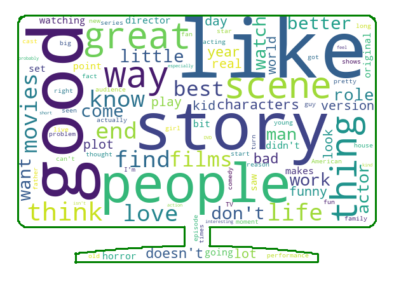

In [41]:
#Word cloud for false positive reviews
wc_pos.generate(predicted_text_pos)

# show
plt.figure(figsize=[15,5])
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

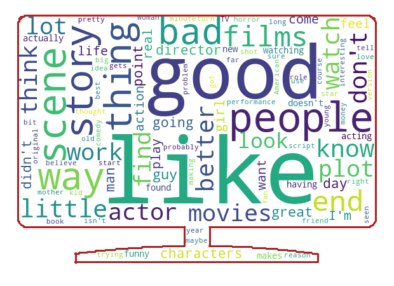

In [42]:
#Word cloud for false negative reviews
wc_neg.generate(predicted_text_neg)

# show
plt.figure(figsize=[15,5])
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

#The words good and like don't help the model to find the correct label

In [43]:
#We try to improve our model by adding some parameters
# we add the parameter min_df = 5 so that a word must appear in 5 reviews to be counted
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
# It reduces the number of word by 3 
print(f"X_train with min_df: {repr(X_train)}")

X_train with min_df: <40000x33645 sparse matrix of type '<class 'numpy.int64'>'
	with 5345857 stored elements in Compressed Sparse Row format>


In [44]:
feature_names = vect.get_feature_names()
print(f"First 50 features:\n{feature_names[:50]}")

First 50 features:
['00', '000', '007', '00pm', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100s', '100th', '101', '102', '103', '104', '105', '107', '108', '109', '10s', '10th', '11', '110', '111', '112', '115', '116', '117', '11th', '12', '120', '1200', '123', '125', '12th', '13', '130', '134', '135', '13th', '14', '140']


In [45]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {np.round(grid.best_score_,3)}")

Best cross-validation score: 0.893


In [46]:
X_test = vect.transform(text_test)
print(f"Test score: {np.round(grid.score(X_test, y_test),3)}")

Test score: 0.893


In [47]:
# We drop the stopwords
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with stop words:\n{repr(X_train)}")

X_train with stop words:
<40000x33339 sparse matrix of type '<class 'numpy.int64'>'
	with 3431372 stored elements in Compressed Sparse Row format>


In [48]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {np.round(grid.best_score_,3)}")

Best cross-validation score: 0.887


In [49]:
X_test = vect.transform(text_test)
print(f"Test score: {np.round(grid.score(X_test, y_test),3)}")

Test score: 0.892


### Tf-idf
\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

In [50]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None, stop_words="english"),
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
#It is the better score since the beginning
print(f"Best cross-validation score: {np.round(grid.best_score_,3)}")
print(f"Best parameters:\n{grid.best_params_}")

Best cross-validation score: 0.893
Best parameters:
{'logisticregression__C': 0.001}


In [51]:
print(f"Test score: {np.round(grid.score(text_test, y_test),3)}")

Test score: 0.895


In [53]:
#We add a new parameter : Bag of words with more than one word (n-grams)
pipe = make_pipeline(TfidfVectorizer(min_df=5, stop_words="english"), LogisticRegression())

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
#We have improved the score 
print(f"Best cross-validation score: {np.round(grid.best_score_,3)}")
print(f"Best parameters:\n{grid.best_params_}")

Best cross-validation score: 0.902
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}


In [54]:
print(f"Test score: {np.round(grid.score(text_test, y_test),3)}")

Test score: 0.904


In [55]:
#Prediction
y_pred = grid.predict(text_test)

In [56]:
#We store our new predictions in the test dataframe
df_test['Predicted'] = y_pred

In [57]:
#Let's see the WordClouds of our wrong predictions
predicted_text_pos = " ".join(df_test.loc[(df_test['Predicted']==1) & (df_test['label']==0), 'text'])
predicted_text_neg = " ".join(df_test.loc[(df_test['Predicted']==0) & (df_test['label']==1), 'text'])

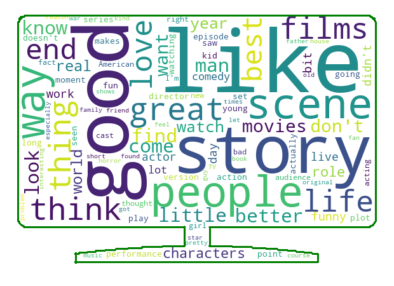

In [58]:
#Word cloud for false positive reviews
wc_pos.generate(predicted_text_pos)

# show
plt.figure(figsize=[15,5])
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

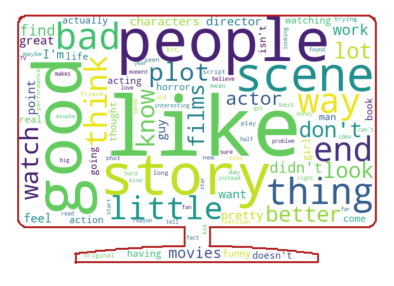

In [59]:
#Word cloud for false negative reviews
wc_neg.generate(predicted_text_neg)

# show
plt.figure(figsize=[15,5])
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

### Possibility of improvement : 

- Stemming
- Lemmatization